<a href="https://colab.research.google.com/github/sahilharidas/JupyterNotebooks/blob/master/Copy_of_timeganstuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series Generative Adversarial Network (TimeGAN)

## Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar: \\
Time-series Generative Adversarial Networks, \\
Neural Information Processing Systems (NeurIPS), 2019.

- Last updated Date: April 24th 2020
- Original code author: Jinsung Yoon (jsyoon0823@gmail.com)

In [1]:
!pip install -uqQ gdown
# !gdown --id 1Pgd9NpQJ7w-Qb1vmXWN_uqaLafy_4Xt3
!gdown --id 1--6WCpNGPtUwLICV5bosHOlh4rHAmEY0

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1--6WCpNGPtUwLICV5bosHOlh4rHAmEY0
To: /content/wiki_prices_ticks.csv
100% 11.0M/11.0M [00:00<00:00, 40.6MB/s]


In [2]:
import warnings
warnings.filterwarnings('ignore')

Mount if stock data stored in drive

In [3]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from pathlib import Path
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

!pip install torchinfo
import torchinfo

import matplotlib.pyplot as plt
import seaborn as sns

# for downloading and storing data
import requests
from io import BytesIO
from zipfile import ZipFile, BadZipFile

import pandas_datareader.data as web
from sklearn.datasets import fetch_openml

pd.set_option('display.expand_frame_repr', False)

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
sns.set_style('white')

## Download and store data

### Set data store path

In [6]:
DATA_STORE = Path('assets.h5')

### Quandl Wiki Prices

Quandl announced the end of community support (updates). The historical data are useful as a first step towards demonstrating the application of the machine learning solutions, just ensure you design and test your own algorithms using current, professional-grade data.


1. Follow the instructions to create a free [NASDAQ account](https://data.nasdaq.com/sign-up)
2. [Download](Download) the entire WIKI/PRICES data
3. Extract the .zip file,
4. Move to this directory and rename to wiki_prices.csv
5. Run the below code to store in fast HDF format (see Chapter 02 on Market & Fundamental Data for details).


Alternatively, instead of all of that, download [this file](https://drive.google.com/file/d/1UgRteM_oc10aI1Eb0co8BRIUKGHXPFId/view?usp=share_link)

In [7]:
# SomethingChanged
# wiki_prices_concat
file_path = 'wiki_prices_ticks.csv'
# if not(os.path.exists(file_path)) and os.path.exists(f'drive/MyDrive/{file_path}'):
#   file_path = f'drive/MyDrive/{file_path}'

df = (pd.read_csv(file_path,
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())

print(df.info(null_counts=True))
with pd.HDFStore(DATA_STORE) as store:
    store.put('quandl/wiki/prices', df)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 84930 entries, (Timestamp('1962-01-02 00:00:00'), 'BA') to (Timestamp('2018-03-27 00:00:00'), 'KO')
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         84930 non-null  float64
 1   high         84930 non-null  float64
 2   low          84930 non-null  float64
 3   close        84930 non-null  float64
 4   volume       84930 non-null  float64
 5   ex-dividend  84930 non-null  float64
 6   split_ratio  84930 non-null  float64
 7   adj_open     84930 non-null  float64
 8   adj_high     84930 non-null  float64
 9   adj_low      84930 non-null  float64
 10  adj_close    84930 non-null  float64
 11  adj_volume   84930 non-null  float64
dtypes: float64(12)
memory usage: 8.6+ MB
None


## Experiment Path

In [8]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [9]:
experiment = 4

In [10]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [11]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

## Prepare data

### Parameters

In [12]:
seq_len = 24
n_seq = 6
batch_size = 128

# torch specific
random_seed = 42
torch.manual_seed(random_seed)

AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [13]:
tickers = ['BA', 'CAT', 'DIS', 'GE', 'IBM', 'KO']

In [14]:
def select_data():
    df = (pd.read_hdf('assets.h5', 'quandl/wiki/prices')
          .adj_close
          .unstack('ticker')
          .loc['2000':, tickers]
          .dropna())
    df.to_hdf(hdf_store, 'data/real')

In [15]:
select_data()

### Plot Series

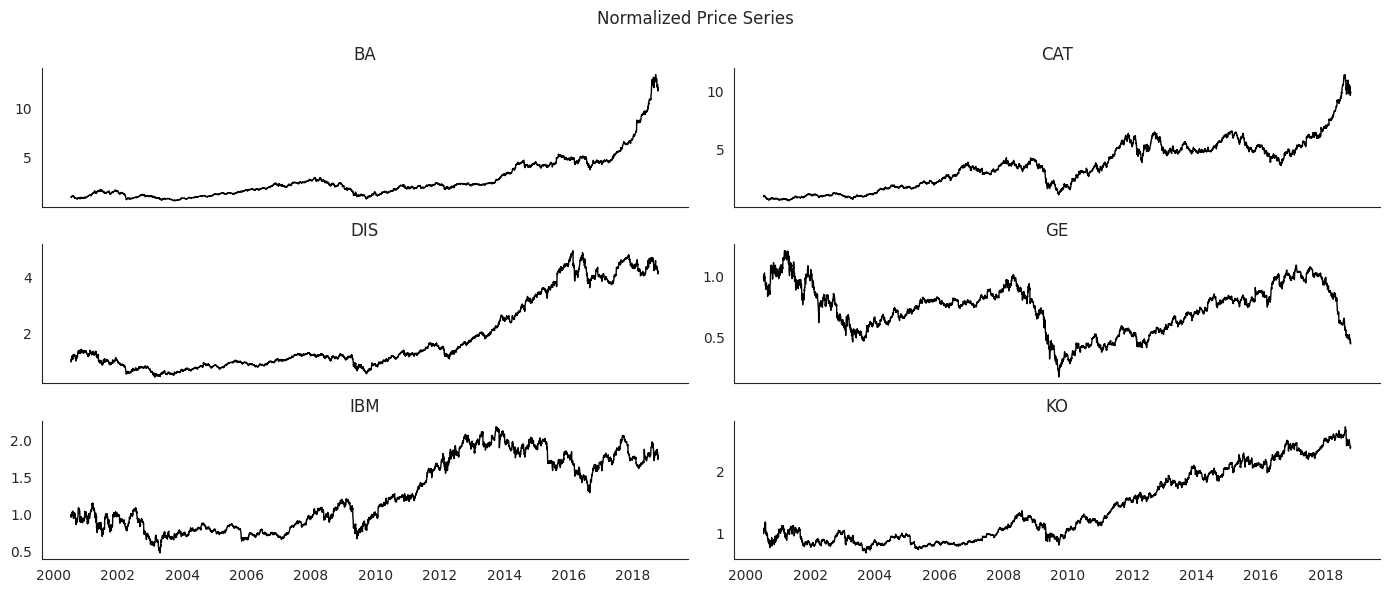

In [16]:
df = pd.read_hdf(hdf_store, 'data/real')
axes = df.div(df.iloc[0]).plot(subplots=True,
                               figsize=(14, 6),
                               layout=(3, 2),
                               title=tickers,
                               legend=False,
                               rot=0,
                               lw=1,
                               color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
sns.despine();

### Correlation

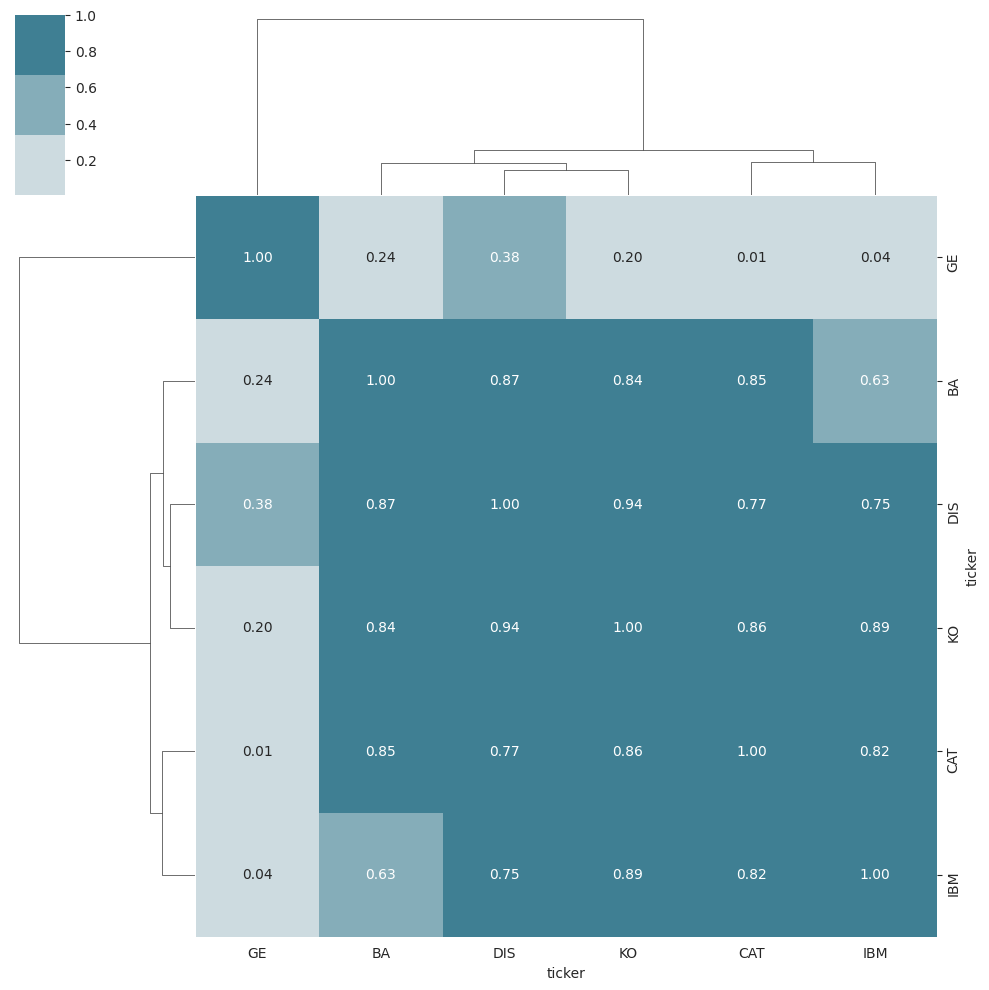

In [17]:
sns.clustermap(
    df.corr(),
    annot=True,
    fmt='.2f',
    cmap=sns.diverging_palette(h_neg=20, h_pos=220),
    center=0
)

### Normalise data

In [18]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

### Create rolling window sequences

In [19]:
data = np.array([scaled_data[i:i + seq_len] for i in range(len(df) - seq_len)])
n_windows = len(data)

### Create torch.utils.data.DataLoader

Do not need buffer_size and repeat() in pytorch as Pytorch will shuffle the data internally.

Can set the number of epochs while creating the DataLoader which will repeat the dataset for specified number of times.

In [20]:
real_series = torch.utils.data.DataLoader(
               torch.from_numpy(data),
               shuffle=True,
               batch_size=batch_size,
               num_workers=NUM_WORKERS,
               drop_last=True
               )
real_series_iter = iter(real_series)

from itertools import cycle
real_series_iter = cycle(real_series_iter)

### Set up random series generator

In [21]:
def make_random_data():
  while True:
    yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

!editpls

We use the Python generator to feed a tf.data.Dataset that continues to call the random number generator as long as necessary and produces the desired batch size

In [22]:
train_steps = 10000
gamma = 1

In [23]:
def make_random_data():
    while True:
        yield torch.rand((batch_size, seq_len, n_seq))

random_series = make_random_data()

## TimeGAN Components

### Network parameters

In [24]:
hidden_dim = 24
num_layers = 3

### Set up logger

You can use the `add_scalar()`, `add_histogram()`, `add_image()` etc methods of the SummaryWriter class to write the various types of data to the tensorboard.

You can also use `with SummaryWriter(log_dir) as writer`: to automatically close the writer once you are done with it.

Also, you could use `log_dir.resolve()` instead of `log_dir.as_posix()` in Pytorch.

In [25]:
writer = SummaryWriter(log_dir.resolve())

### RNN block generator


In [26]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3):
        super(RNN, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.fc(x)
        return torch.sigmoid(x)

###  Embedder & Recovery

In [27]:
embedder = RNN(n_seq, hidden_dim, hidden_dim).to(device)
recovery = RNN(hidden_dim, hidden_dim, n_seq).to(device)

In [28]:
input_shape = (batch_size, seq_len, n_seq) # torch.Size([128, 24, 6])
dummy_input = torch.randn(input_shape).to(device)

embedded_data = embedder(dummy_input)
recovered_data = recovery(embedded_data)
embedded_data.shape, recovered_data.shape

(torch.Size([128, 24, 24]), torch.Size([128, 24, 6]))

### Generator & Discriminator

It's important to note that the supervisor network is not mandatory to use in TimeGAN and its usage might be dependent on the specific dataset and problem you are trying to solve.

In [29]:
generator = RNN(n_seq, hidden_dim, hidden_dim).to(device)
discriminator = RNN(hidden_dim, hidden_dim, 1).to(device)
supervisor = RNN(hidden_dim, hidden_dim, hidden_dim, 2).to(device)

## TimeGAN Training

### Settings

Settings have been done when setting the random series generator

### Generic Loss Functions

In [30]:
mse = nn.MSELoss()
bce = nn.BCELoss()

# Phase 1: Autoencoder Training

An autoencoder is a neural network architecture that is trained to reconstruct its input. It consists of two main components: an encoder and a decoder. The encoder maps the input data to a lower-dimensional representation (also known as the bottleneck or latent representation), and the decoder maps the bottleneck representation back to the original input space. The goal of the autoencoder is to learn a compact and informative representation of the input data that can be used for various tasks, such as data compression, denoising, and anomaly detection.

In the given notebook, the autoencoder architecture is composed of an `embedder` model and a `recovery` model. The `embedder` model is responsible for encoding the input data and the `recovery` model is responsible for decoding the encoded data. The `embedder` and `recovery` models are combined to form the autoencoder, where the output of the `embedder` model is passed as input to the `recovery` model.

The `embedder` model is a one-layer LSTM model with a hidden size of 24 and the `recovery` model is also a one-layer LSTM model, but with a hidden size of 6. The `embedder` maps the input data to a lower-dimensional representation with 24 dimensions, and the `recovery` maps this representation back to the original input space with 6 dimensions.

The autoencoder is trained using the Mean Squared Error (MSE) loss function, which measures the difference between the input and the reconstructed output. The goal of the training is to minimize this MSE loss and learn a good representation of the input data.

The output of the autoencoder (`x_tilde`) is then used as input for the TimeGAN, which is an extension of the GAN architecture that is designed to generate synthetic time series data. The TimeGAN architecture is composed of a generator, a discriminator, and a supervisor. The generator generates synthetic data, the discriminator discriminates between real and synthetic data, and the supervisor guides the generator to produce realistic synthetic data.


## Architecture

In [31]:
class Autoencoder(nn.Module):
    def __init__(self, embedder, recovery):
        # super(Autoencoder, self).__init__()
        super().__init__()
        self.embedder = embedder
        self.recovery = recovery

        # self.embedder =

    def forward(self, X):
        H = self.embedder(X) # embedded_data
        X_tilde = self.recovery(H) # recovered_data
        return X_tilde

autoencoder = Autoencoder(embedder, recovery)

In [32]:
print(autoencoder)

Autoencoder(
  (embedder): RNN(
    (gru): GRU(6, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=24, bias=True)
  )
  (recovery): RNN(
    (gru): GRU(24, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=6, bias=True)
  )
)


## Autoencoder Optimizer

In [33]:
autoencoder_optimizer = optim.Adam(autoencoder.parameters()) #lr, weight_decay could be specified here

## Autoencoder Training Step

In [34]:
def train_autoencoder_init(x):
    x_tilde = autoencoder(x)
    loss = mse(x, x_tilde)
    autoencoder_loss = 10 * torch.sqrt(loss)
    autoencoder_loss.backward()
    autoencoder_optimizer.step()
    autoencoder_optimizer.zero_grad()
    return torch.sqrt(loss)

## Autoencoder Training Loop

In [35]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter).to(device)
    step_e_loss_t0 = train_autoencoder_init(X_)
    writer.add_scalar('Loss Autoencoder Init', step_e_loss_t0, step)

100%|██████████| 10000/10000 [00:51<00:00, 194.59it/s]


## Persist model

In [36]:
torch.save(autoencoder, log_dir / 'autoencoder')
autoencoder = torch.load(log_dir / 'autoencoder').to(device)
autoencoder.eval()

Autoencoder(
  (embedder): RNN(
    (gru): GRU(6, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=24, bias=True)
  )
  (recovery): RNN(
    (gru): GRU(24, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=6, bias=True)
  )
)

# Phase 2: Supervised Training

## Define Optimiser

In [37]:
supervisor_optimizer = optim.Adam(autoencoder.parameters())

## Train Step

In this code, `train_supervisor` is defined as a function that takes in input `x`. The `embedder` and `supervisor` models are used to compute the `h` and `h_hat_supervised` respectively. The Mean Squared Error loss is calculated between the `h[:, 1:, :]` and `h_hat_supervised[:, :-1, :]`.
Then the optimizer is used to update the parameters of the `supervisor` model. `optimizer.step()` performs a single optimization step (parameter update). `optimizer.zero_grad()` is used to clear the gradients of all optimized torch.Tensor s.
Note that in PyTorch there is no need to use `tf.function` and `tf.GradientTape` . Instead, Pytorch uses autograd for computing gradients and `backward()` for backpropagation.

In [38]:
def train_supervisor(x):
    x.requiresGrad = True
    h = embedder(x)
    h_hat_supervised = supervisor(h)
    g_loss_s = nn.MSELoss()(h[:, 1:, :], h_hat_supervised[:, :-1, :])
    g_loss_s.backward()
    supervisor_optimizer.step()
    supervisor_optimizer.zero_grad()
    return g_loss_s

## Training Loop

In [39]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter).to(device)
    step_g_loss_s = train_supervisor(X_)
    writer.add_scalar('Loss Generator Supervised Init', step_g_loss_s, step)

100%|██████████| 10000/10000 [00:31<00:00, 321.60it/s]


## Persist model

In [40]:
torch.save(supervisor, log_dir / 'supervisor')
supervisor = torch.load(log_dir / 'supervisor').to(device)
supervisor.eval()

RNN(
  (gru): GRU(24, 24, num_layers=2, batch_first=True)
  (fc): Linear(in_features=24, out_features=24, bias=True)
)

# Joint Training

## Generator

### Adversarial Architecture - Supervised

In [41]:
Z = torch.randn((batch_size, seq_len, n_seq)).to(device)
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

modules = nn.ModuleList([generator, supervisor, discriminator])
adversarial_supervised = nn.Sequential(*modules)
adversarial_supervised.name = 'AdversarialNetSupervised'

In [42]:
print(adversarial_supervised)

Sequential(
  (0): RNN(
    (gru): GRU(6, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=24, bias=True)
  )
  (1): RNN(
    (gru): GRU(24, 24, num_layers=2, batch_first=True)
    (fc): Linear(in_features=24, out_features=24, bias=True)
  )
  (2): RNN(
    (gru): GRU(24, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=1, bias=True)
  )
)


### Adversarial Architecture in Latent Space

In [43]:
class AdversarialNet(nn.Module):
    def __init__(self, generator, discriminator):
        super(AdversarialNet, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, x):
        e_hat = self.generator(x)
        y_fake_e = self.discriminator(e_hat)
        return y_fake_e

adversarial_emb = AdversarialNet(generator, discriminator).to(device)
adversarial_emb.name = 'AdversarialNet'

In [44]:
print(adversarial_emb)

AdversarialNet(
  (generator): RNN(
    (gru): GRU(6, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=24, bias=True)
  )
  (discriminator): RNN(
    (gru): GRU(24, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=1, bias=True)
  )
)


### Mean & Variance Loss

In [45]:
class SyntheticData(nn.Module):
    def __init__(self, generator, supervisor, recovery):
        super(SyntheticData, self).__init__()
        self.generator = generator
        self.supervisor = supervisor
        self.recovery = recovery

    def forward(self, x):
        e_hat = self.generator(x)
        h_hat = self.supervisor(e_hat)
        x_hat = self.recovery(h_hat)
        return x_hat

synthetic_data = SyntheticData(generator, supervisor, recovery).to(device)
synthetic_data.name = 'SyntheticData'

In [46]:
print(synthetic_data)

SyntheticData(
  (generator): RNN(
    (gru): GRU(6, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=24, bias=True)
  )
  (supervisor): RNN(
    (gru): GRU(24, 24, num_layers=2, batch_first=True)
    (fc): Linear(in_features=24, out_features=24, bias=True)
  )
  (recovery): RNN(
    (gru): GRU(24, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=6, bias=True)
  )
)


In [47]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean = torch.mean(y_true, dim=0)
    y_true_var = torch.var(y_true, dim=0) + 1e-6
    y_pred_mean = torch.mean(y_pred, dim=0)
    y_pred_var = torch.var(y_pred, dim=0) + 1e-6
    g_loss_mean = torch.mean(torch.abs(y_true_mean - y_pred_mean))
    g_loss_var = torch.mean(torch.abs(torch.sqrt(y_true_var) - torch.sqrt(y_pred_var)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [48]:
discriminator_model = nn.Sequential(embedder, discriminator).to(device)

In [49]:
print(discriminator_model)

Sequential(
  (0): RNN(
    (gru): GRU(6, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=24, bias=True)
  )
  (1): RNN(
    (gru): GRU(24, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=1, bias=True)
  )
)


## Optimisers

In [50]:
generator_optimizer = optim.Adam(generator.parameters())
discriminator_optimizer = optim.Adam(discriminator.parameters())
embedding_optimizer = optim.Adam(embedder.parameters())

## Generator Train Step

In [51]:
def train_generator(x, z):
    # Calculate generator losses
    y_fake = adversarial_supervised(z)
    generator_loss_unsupervised = bce(y_fake, torch.ones_like(y_fake))

    y_fake_e = adversarial_emb(z)
    generator_loss_unsupervised_e = bce(y_fake_e, torch.ones_like(y_fake_e))

    h = embedder(x)
    h_hat_supervised = supervisor(h)
    generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    x_hat = synthetic_data(z)
    generator_moment_loss = get_generator_moment_loss(x, x_hat)

    generator_loss = (generator_loss_unsupervised +
                      generator_loss_unsupervised_e +
                      100 * torch.sqrt(generator_loss_supervised) +
                      100 * generator_moment_loss)

    # Calculate gradients and update generator and supervisor parameters
    generator.zero_grad()
    supervisor.zero_grad()
    generator_loss.backward()
    generator_optimizer.step()
    supervisor_optimizer.step()
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss


## Embedding Train Step

In [52]:
def train_embedder(x):
    h = embedder(x)
    h_hat_supervised = supervisor(h)
    generator_loss_supervised = nn.MSELoss()(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    x_tilde = autoencoder(x)
    embedding_loss_t0 = nn.MSELoss()(x, x_tilde)
    e_loss = 10 * torch.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    optimizer = torch.optim.Adam(list(embedder.parameters()) + list(recovery.parameters()), lr=0.001)
    optimizer.zero_grad()
    e_loss.backward()
    optimizer.step()
    return torch.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [53]:
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = nn.BCELoss()(y_real, torch.ones_like(y_real))

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = nn.BCELoss()(y_fake, torch.zeros_like(y_fake))

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = nn.BCELoss()(y_fake_e, torch.zeros_like(y_fake_e))
    return discriminator_loss_real + discriminator_loss_fake + gamma * discriminator_loss_fake_e

In [54]:
def train_discriminator(x, z):
    discriminator_loss = get_discriminator_loss(x, z)

    discriminator_optimizer.zero_grad()
    discriminator_loss.backward()
    discriminator_optimizer.step()
    return discriminator_loss

## Training Loop

In [55]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
autoencoder.train()
supervisor.train()
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter).to(device)
        Z_ = next(random_series).to(device)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter).to(device)
    Z_ = next(random_series).to(device)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')


     0 | d_loss: 2.1302 | g_loss_u: 0.6455 | g_loss_s: 0.0774 | g_loss_v: 0.3667 | e_loss_t0: 0.0487
 1,000 | d_loss: 1.6943 | g_loss_u: 0.7247 | g_loss_s: 0.0000 | g_loss_v: 0.3731 | e_loss_t0: 0.2291
 2,000 | d_loss: 2.0055 | g_loss_u: 0.9099 | g_loss_s: 0.0000 | g_loss_v: 0.3705 | e_loss_t0: 0.4185
 3,000 | d_loss: 0.1503 | g_loss_u: 4.6621 | g_loss_s: 0.0000 | g_loss_v: 0.3494 | e_loss_t0: 0.4082
 4,000 | d_loss: 0.1250 | g_loss_u: 5.0039 | g_loss_s: 0.0000 | g_loss_v: 0.3398 | e_loss_t0: 0.4095
 5,000 | d_loss: 3.8193 | g_loss_u: 3.4348 | g_loss_s: 0.0000 | g_loss_v: 0.3491 | e_loss_t0: 0.4214
 6,000 | d_loss: 2.2159 | g_loss_u: 0.8853 | g_loss_s: 0.0000 | g_loss_v: 0.3339 | e_loss_t0: 0.3914
 7,000 | d_loss: 1.5284 | g_loss_u: 1.2228 | g_loss_s: 0.0000 | g_loss_v: 0.3519 | e_loss_t0: 0.4196
 8,000 | d_loss: 1.8872 | g_loss_u: 1.1664 | g_loss_s: 0.0000 | g_loss_v: 0.3907 | e_loss_t0: 0.4251
 9,000 | d_loss: 1.5212 | g_loss_u: 1.9985 | g_loss_s: 0.0000 | g_loss_v: 0.3764 | e_loss_t

## Persist Synthetic Data Generator


In [56]:
torch.save(synthetic_data, log_dir / 'synthetic_data') # uncomment if not using saved model files
synthetic_data = torch.load(log_dir / 'synthetic_data')
synthetic_data.eval()

SyntheticData(
  (generator): RNN(
    (gru): GRU(6, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=24, bias=True)
  )
  (supervisor): RNN(
    (gru): GRU(24, 24, num_layers=2, batch_first=True)
    (fc): Linear(in_features=24, out_features=24, bias=True)
  )
  (recovery): RNN(
    (gru): GRU(24, 24, num_layers=3, batch_first=True)
    (fc): Linear(in_features=24, out_features=6, bias=True)
  )
)

# Generate Synthetic Data

In [57]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series).to(device)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [58]:
len(generated_data)

35

In [59]:
generated_data = np.array(np.vstack([d.detach().cpu().numpy() for d in generated_data]))
generated_data.shape

(4480, 24, 6)

In [60]:
np.save(log_dir / 'generated_data.npy', generated_data)

## Rescale

In [61]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(4480, 24, 6)

## Persist Data

In [62]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=tickers))

## Plot Sample Series

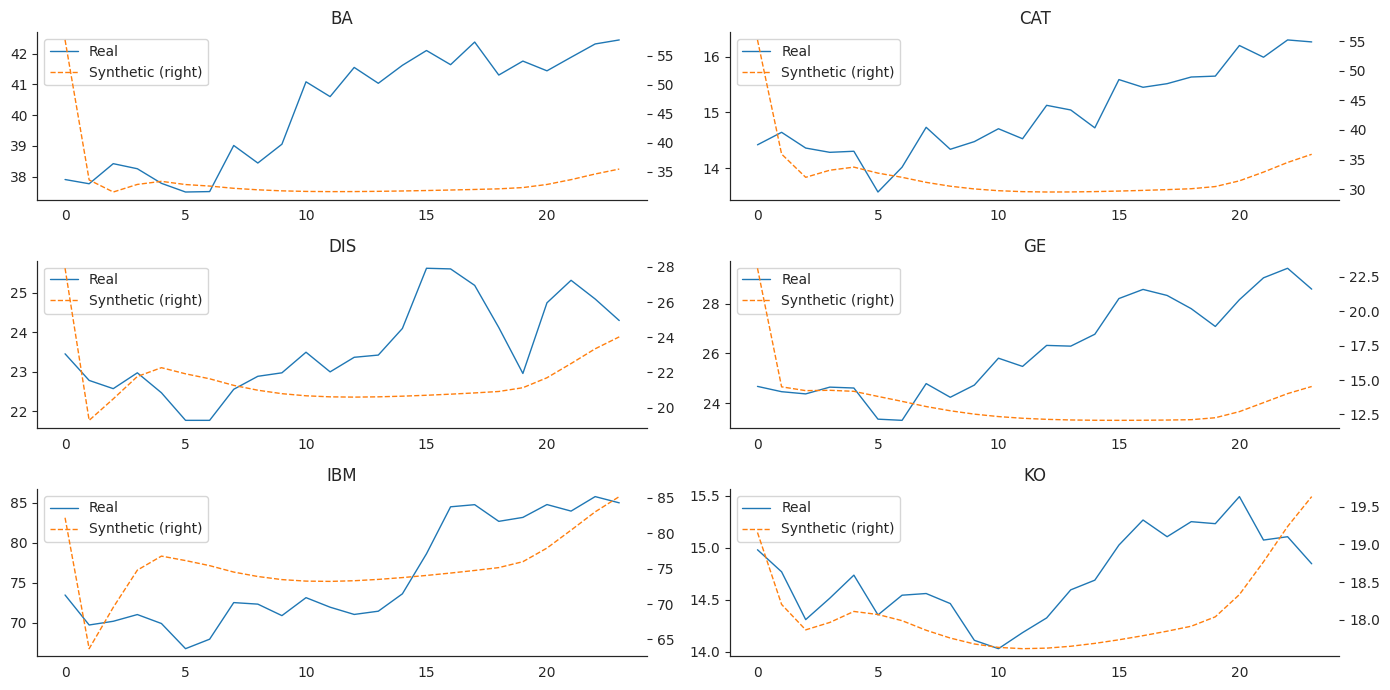

In [64]:
#SomethingChanged
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values,
                   'Synthetic': synthetic[:, j]})
     .plot(ax=axes[j],
           title=ticker,
           secondary_y='Synthetic', style=['-', '--'],
           lw=1))
sns.despine()
fig.tight_layout()

# Visualize Real and Synthetic Data

## Load Data

In [65]:
path = Path('time_gan')

In [66]:
def get_real_data():
    df = pd.read_hdf(hdf_store, 'data/real').sort_index()

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data


real_data = get_real_data()

In [67]:
n = len(real_data)

In [68]:
np.asarray(real_data).shape

(4562, 24, 6)

In [69]:
synthetic_data = np.load(path / f'experiment_{experiment:02d}' / 'generated_data.npy')
synthetic_data.shape

(4480, 24, 6)

In [70]:
real_data = real_data[:synthetic_data.shape[0]]

## Prepare Sample

In [71]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [72]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [73]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [74]:
real_sample_2d.shape, synthetic_sample_2d.shape

((1500, 24), (1500, 24))

## Visualization in 2D: A Qualitative Assessment of Diversity

### Run PCA

In [75]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

### Plot t-SNE

In [76]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.641s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.000126
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.144859
[t-SNE] KL divergence after 1000 iterations: 0.226109


In [77]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

### Plot result

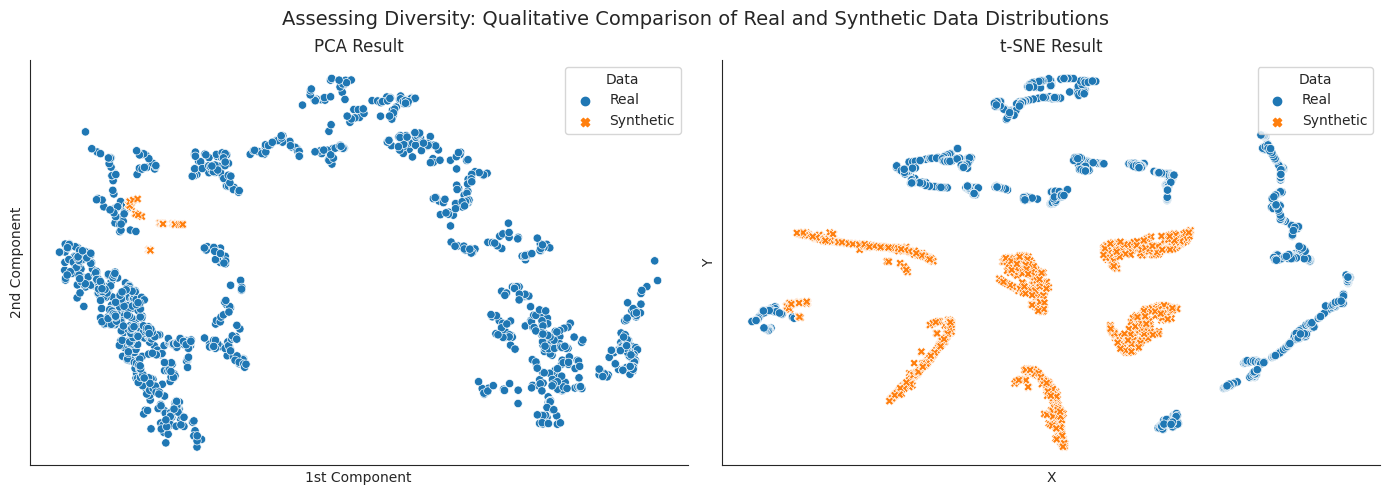

In [78]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data',
                style='Data',
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions',
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);